In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
import filtering
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Good/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240612_Slice_day_1',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240607_K+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240610_Ca+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240611_SingleChannel']

In [3]:
files = glob(folders[0]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0002.abf']

In [4]:
get_protocol(files)

['Glutamate Test Sweep',
 'Glutamate Test Sweep',
 'Glutamate Test Sweep',
 'Glutamate Test Sweep',
 'Glutamate Test Sweep',
 'None',
 'None',
 'One Stim']

In [5]:
Glu_files = files_from_protocol('Glu',files)
Glu_files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0003.abf']

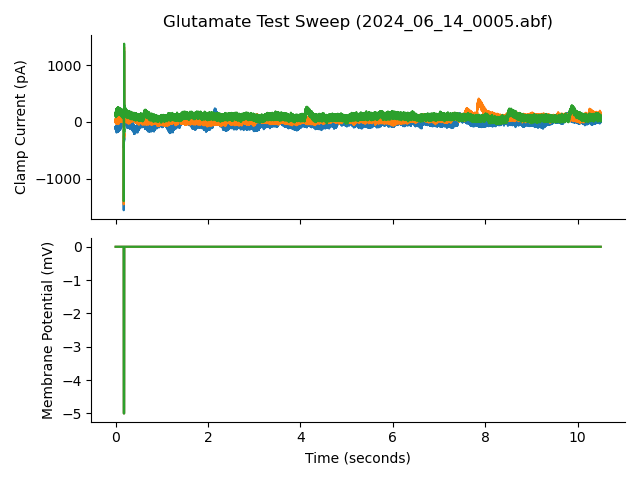

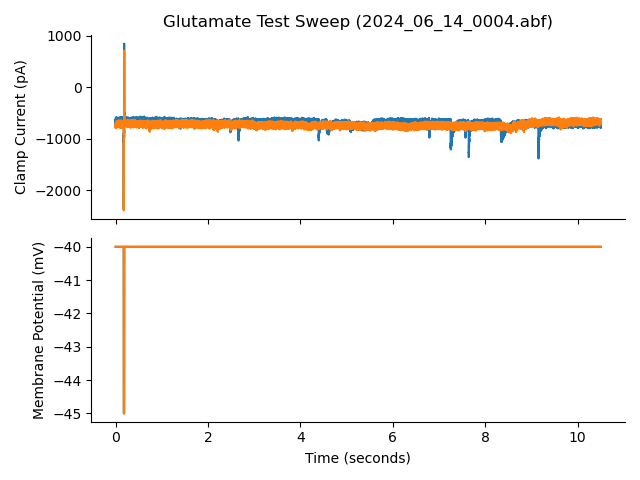

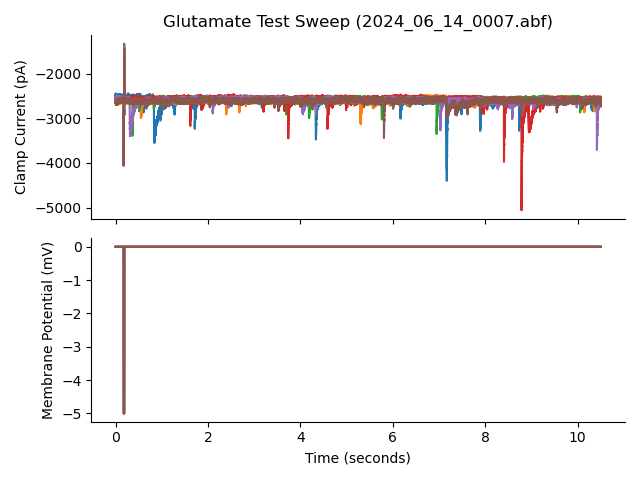

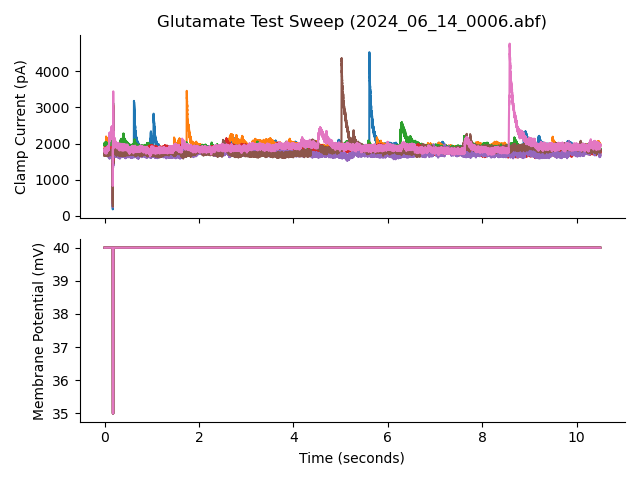

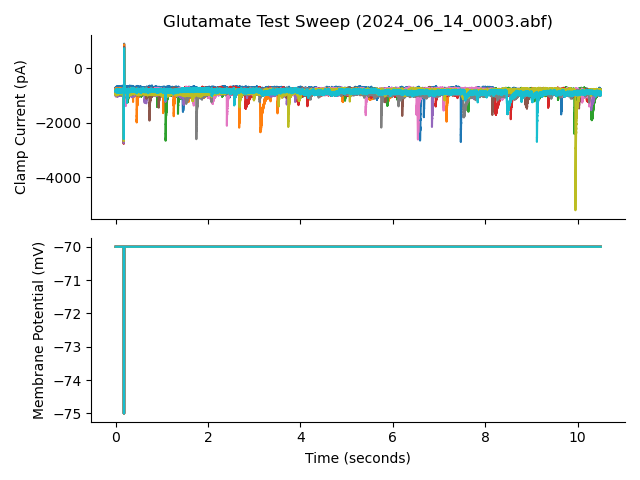

In [6]:
plt.close('all')
for f in Glu_files:
    plot_swps(f)

In [7]:
Glu_files = Glu_files[2:]

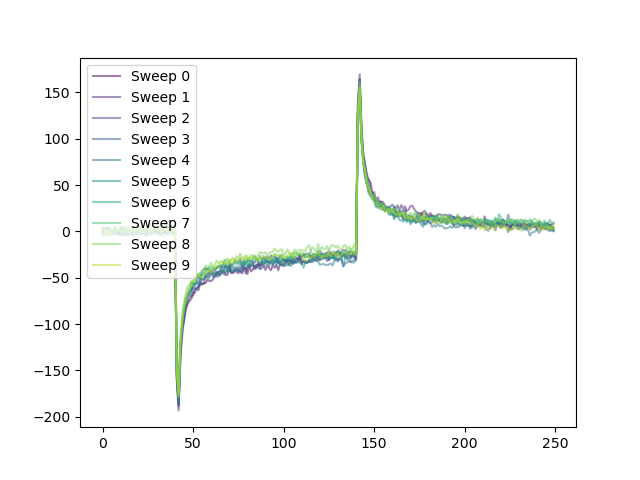

In [8]:
f = Glu_files[-1]
swps, swp_time, sr = get_sweeps(f)
swps /= 10
seal_test = swp_window(swps,0.170,0.195,sr,channel=0)
cmap = mp.colormaps['viridis']
fig,ax = plt.subplots()
for i,test in enumerate(seal_test):
    color = cmap(i/len(seal_test))[:-1]
    ax.plot(test - np.mean(test[:10]),alpha=0.5,color=color,label = f'Sweep {i}')
ax.legend()

In [9]:
gap_free = swp_window(swps,0.2,12,sr,channel=0)
v = np.mean(swp_window(swps,0.2,12,sr,channel=1))
v*10

-70.0

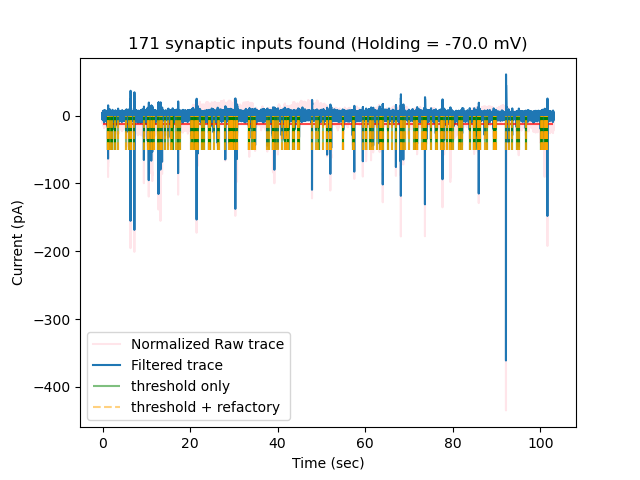

In [45]:
plt.close('all')
full_trace = np.array([c-np.mean(c[:10]) for c in gap_free]).flatten()
dt = 1/sr
full_filt = filtering.bandpass(full, dt*1e3, 0.025,2)
thresh = -12
time = np.arange(len(full))/sr
is_input = (full_filt[:-1]>thresh) * (full_filt[1:]<=thresh)
where_input = np.where(is_input)[0]
ref_t = 10e-3
refact = int(ref_t/dt)
ref = 0
where_syn = []
for i in where_input:
    if i<ref:
        continue
    else:
        syn = full_filt[i:i+refact]
    if syn.max() < thresh:
        continue
    else:
        where_syn.append(i)
        ref = i+refact
where_syn = np.array(where_syn)
fig,ax = plt.subplots()
ax.plot(time,full,alpha=0.4,color='pink',label='Normalized Raw trace')
ax.plot(time,full_filt,label='Filtered trace')
ax.hlines(thresh,time[1],time[-1],alpha=0.7,color='red',linestyles='solid')
ax.vlines(where_input*dt,-50,0,alpha=0.5,color='green',linestyles='solid')
ax.vlines(where_syn*dt,-50,0,alpha=0.8,color='orange',linestyles='dashed')
#Legend
ax.vlines(0,0,0,alpha=0.5,color='green',linestyles='solid',label='threshold only')
ax.vlines(0,0,0,alpha=0.5,color='orange',linestyles='dashed',label='threshold + refactory')
ax.set_title(f'{len(where_syn)} synaptic inputs found (Holding = {v*10} mV)')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (sec)')
ax.legend()
plt.show()

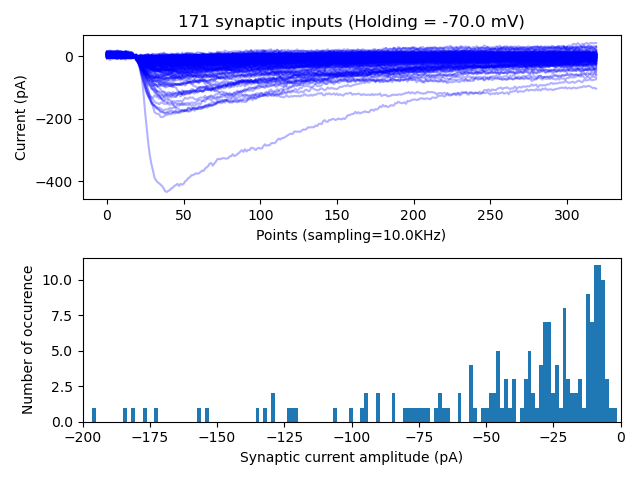

In [47]:
before = 2 # ms
after = 30 # ms
i_b = int(before*1e-3/dt)
i_a = int(after*1e-3/dt)
synaptic_input = np.array([full_trace[syn_i-i_b:syn_i+i_a]-np.mean(full_trace[syn_i-int(i_b/10)])  
                           for syn_i in where_syn])
amps = np.min(synaptic_input,axis=1)
fig,ax = plt.subplots(2)
ax[0].plot(synaptic_input.T,alpha=0.3,color='blue')
ax[0].set_xlabel(f'Points (sampling={sr*1e-3}KHz)')
ax[0].set_ylabel('Current (pA)')
counts,bins = np.histogram(amps,300)
ax[1].hist(bins[:-1], bins, weights=counts)
ax[1].set_xlim(-200,0)
ax[1].set_xlabel('Synaptic current amplitude (pA)')
ax[1].set_ylabel('Number of occurence')
ax[0].set_title(f'{len(where_syn)} synaptic inputs (Holding = {v*10} mV)')
fig.tight_layout()
plt.show()

In [80]:
def syn_curr(f):
    swps, swp_time, sr = get_sweeps(f)
    swps /= 10
    v = np.mean(swp_window(swps,0.2,12,sr,channel=1))
    v = int(v*10)
    seal_test = swp_window(swps,0.170,0.195,sr,channel=0)
    cmap = mp.colormaps['viridis']
    fig,ax = plt.subplots()
    for i,test in enumerate(seal_test):
        color = cmap(i/len(seal_test))[:-1]
        ax.plot(test - np.mean(test[:10]),alpha=0.5,color=color,label = f'Sweep {i}')
    ax.legend()
    plt.show()
    gap_free = swp_window(swps,0.2,12,sr,channel=0)
    full_trace = np.array([c-np.mean(c[:10]) for c in gap_free]).flatten()
    dt = 1/sr
    full_filt = filtering.bandpass(full_trace, dt*1e3, 0.025,2)
    if v <= 0:
        thresh = -12
        is_input = (full_filt[:-1]>thresh) * (full_filt[1:]<=thresh)
    elif v >= 40:
        thresh = 12
        is_input = (full_filt[:-1]<thresh) * (full_filt[1:]>=thresh)
    else:
        print(f'Error Holding Voltage is : {v} mV')
        return None
    time = np.arange(len(full_trace))/sr
    where_input = np.where(is_input)[0]
    ref_t = 10e-3
    refact = int(ref_t/dt)
    ref = 0
    where_syn = []
    for i in where_input:
        if i<ref:
            continue
        else:
            syn = full_filt[i:i+refact]
        if syn.max() < thresh:
            continue
        else:
            where_syn.append(i)
            ref = i+refact
    where_syn = np.array(where_syn)
    fig,ax = plt.subplots()
    ax.plot(time,full_trace,alpha=0.4,color='pink',label='Normalized Raw trace')
    ax.plot(time,full_filt,label='Filtered trace')
    ax.hlines(thresh,time[1],time[-1],alpha=0.7,color='red',linestyles='solid',label='Threshold')
    ax.vlines(where_input*dt,-50,0,alpha=0.5,color='green',linestyles='solid')
    ax.vlines(where_syn*dt,-50,0,alpha=0.8,color='orange',linestyles='dashed')
    #Legend
    ax.vlines(0,0,0,alpha=0.5,color='green',linestyles='solid',label='threshold only')
    ax.vlines(0,0,0,alpha=0.5,color='orange',linestyles='dashed',label='threshold + refactory')
    ax.set_title(f'{len(where_syn)} synaptic inputs found (Holding = {v} mV)')
    ax.set_ylabel('Current (pA)')
    ax.set_xlabel('Time (sec)')
    ax.legend()
    plt.show()
    before = 2 # ms
    after = 30 # ms
    i_b = int(before*1e-3/dt)
    i_a = int(after*1e-3/dt)
    synaptic_input = np.array([full_trace[syn_i-i_b:syn_i+i_a]-np.mean(full_trace[syn_i-int(i_b/10)])  
                               for syn_i in where_syn])
    if v <= 0:
        amps = np.min(synaptic_input,axis=1)
    elif v >= 40:
        amps = np.max(synaptic_input,axis=1)
    fig,ax = plt.subplots(2)
    ax[0].plot(synaptic_input.T,alpha=0.3,color='blue')
    ax[0].set_xlabel(f'Points (sampling={sr*1e-3}KHz)')
    ax[0].set_ylabel('Current (pA)')
    counts,bins = np.histogram(amps,250)
    ax[1].hist(bins[:-1], bins, weights=counts)
    # ax[1].set_xlim(-200,0)
    ax[1].set_xlabel('Synaptic current amplitude (pA)')
    ax[1].set_ylabel('Number of occurence')
    ax[0].set_title(f'{len(where_syn)} synaptic inputs (Holding = {v} mV)')
    fig.tight_layout()
    plt.show()

/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0007.abf


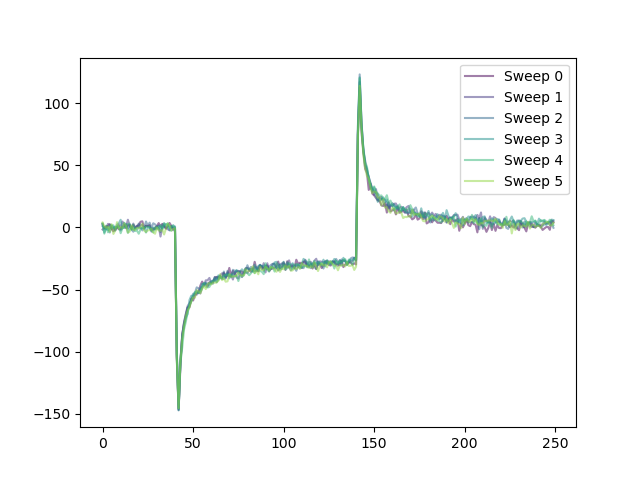

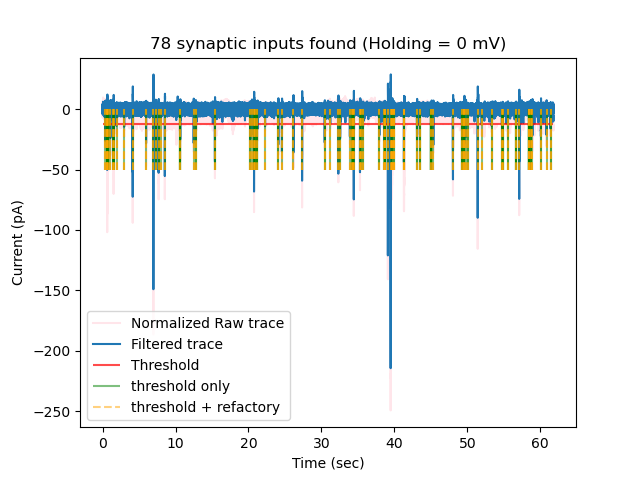

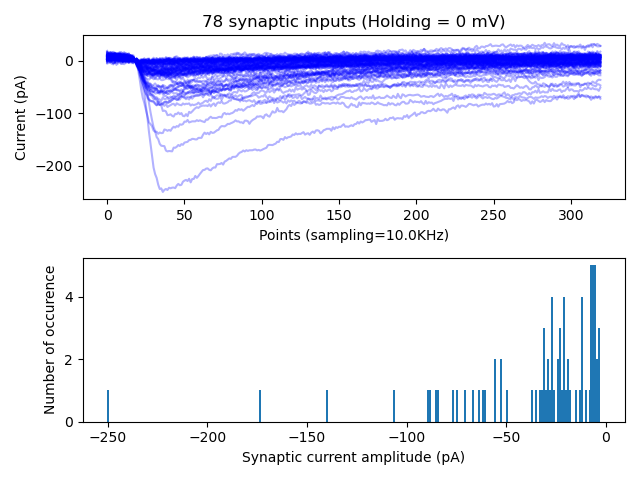

/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0006.abf


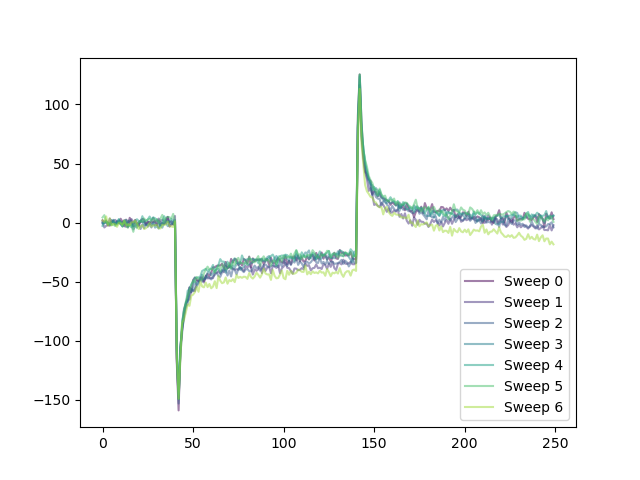

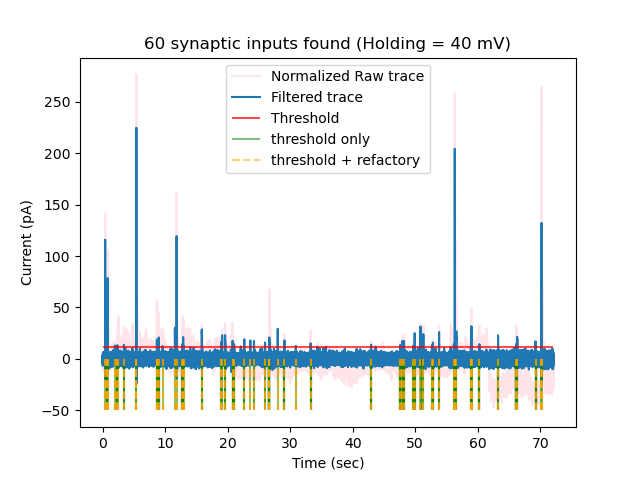

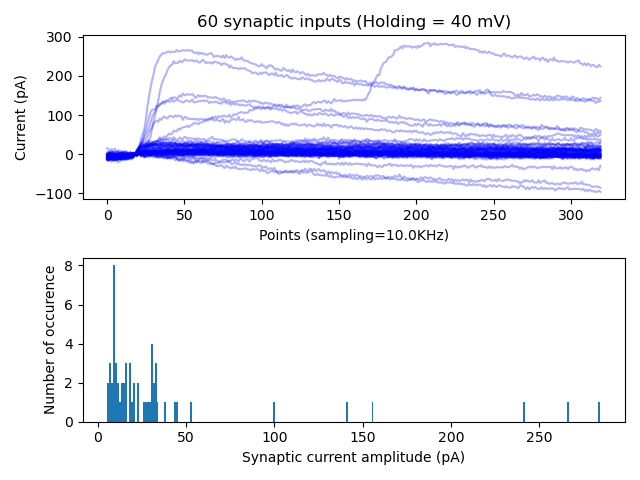

/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked/2024_06_14_0003.abf


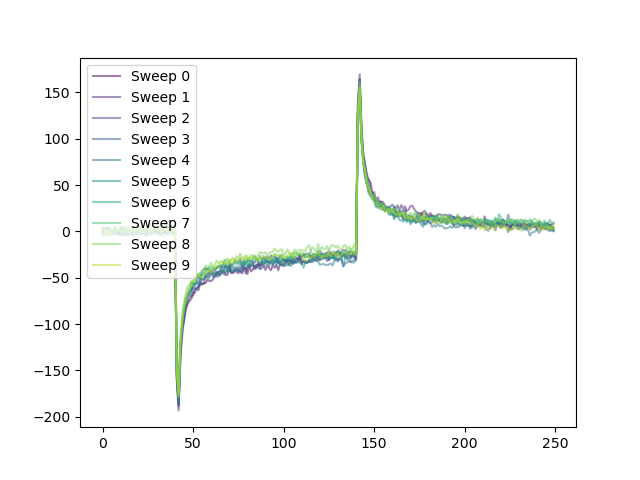

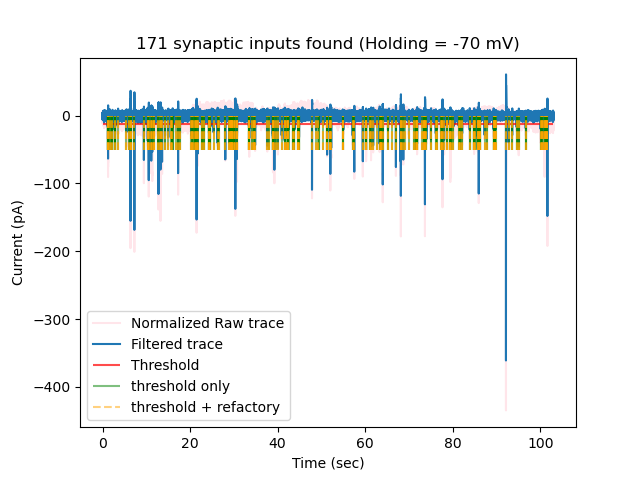

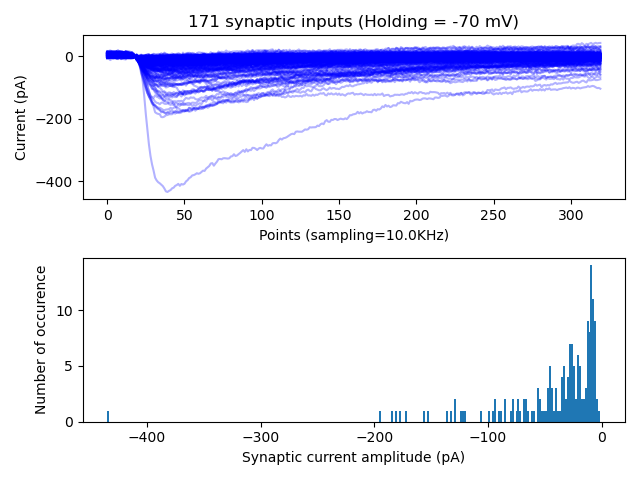

In [81]:
plt.close('all')
for f in Glu_files:
    print(f)
    syn_curr(f)